In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report

In [2]:
df_cleaned=pd.read_csv('human_vital_signs_dataset_2024.csv')

In [3]:
# Drop irrelevant columns
df_cleaned = df_cleaned.drop(columns=["Patient ID", "Timestamp", "Systolic Blood Pressure", "Diastolic Blood Pressure", 
                              "Derived_HRV", "Derived_Pulse_Pressure", "Derived_BMI", "Derived_MAP"])

# Convert 'Gender' to numerical format
df_cleaned['Gender'] = df_cleaned['Gender'].map({'Male': 0, 'Female': 1})

# Encode target variable 'Risk Category'
label_encoder = LabelEncoder()
df_cleaned['Risk Category'] = label_encoder.fit_transform(df_cleaned['Risk Category'])

# Define features and target
X_filtered = df_cleaned[["Heart Rate", "Respiratory Rate", "Body Temperature", "Oxygen Saturation",
                         "Age", "Height (m)", "Weight (kg)", "Gender"]]
y_filtered = df_cleaned["Risk Category"]


In [4]:
X_train_f, X_test_f, y_train_f, y_test_f = train_test_split(
    X_filtered, y_filtered, test_size=0.3, random_state=42, stratify=y_filtered)


In [5]:
# Define models
models_filtered = {
    "Random Forest": RandomForestClassifier(n_estimators=50, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=50, random_state=42),
    "Naïve Bayes": GaussianNB(),
    # "Support Vector Machine": SVC(kernel='linear', random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    # "K-Nearest Neighbors": KNeighborsClassifier(n_neighbors=5),
    "Decision Tree": DecisionTreeClassifier(random_state=42)
}

In [6]:
df_cleaned.columns

Index(['Heart Rate', 'Respiratory Rate', 'Body Temperature',
       'Oxygen Saturation', 'Age', 'Gender', 'Weight (kg)', 'Height (m)',
       'Risk Category'],
      dtype='object')

In [7]:
# Train and evaluate models
results_filtered = {}
for name, model in models_filtered.items():
    model.fit(X_train_f, y_train_f)
    y_pred_f = model.predict(X_test_f)
    accuracy = accuracy_score(y_test_f, y_pred_f)
    results_filtered[name] = {
        "Model": model,
        "Accuracy": accuracy,
        "Report": classification_report(y_test_f, y_pred_f)
    }



Model: Random Forest
Accuracy: 99.51%
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     31535
           1       0.99      1.00      0.99     28471

    accuracy                           1.00     60006
   macro avg       0.99      1.00      1.00     60006
weighted avg       1.00      1.00      1.00     60006


Model: Gradient Boosting
Accuracy: 96.57%
              precision    recall  f1-score   support

           0       1.00      0.94      0.97     31535
           1       0.93      1.00      0.97     28471

    accuracy                           0.97     60006
   macro avg       0.97      0.97      0.97     60006
weighted avg       0.97      0.97      0.97     60006


Model: Naïve Bayes
Accuracy: 67.60%
              precision    recall  f1-score   support

           0       0.71      0.66      0.68     31535
           1       0.65      0.70      0.67     28471

    accuracy                           0.68     60006
   macro 

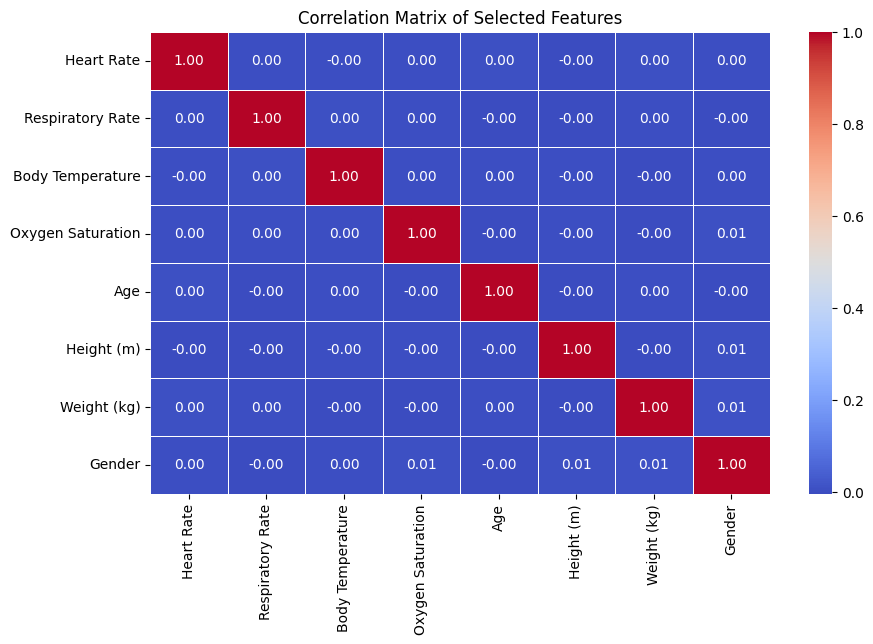

In [8]:
# Print results
for model_name, result in results_filtered.items():
    print(f"\nModel: {model_name}")
    print(f"Accuracy: {result['Accuracy']:.2%}")
    print(result['Report'])

# Compute and plot correlation matrix
correlation_matrix = X_filtered.corr()
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix of Selected Features")
plt.show()


In [9]:
# Function to classify health status
def classify_health(heart_rate, resp_rate, spo2, temp, age, gender):
    risk_level = "Normal"
    condition = "Healthy"
    
    # Normal Ranges
    normal_hr = (60, 100) if age >= 18 else (70, 120)
    normal_resp = (12, 20) if age >= 18 else (20, 30)
    normal_spo2 = (95, 100)
    normal_temp = (36.1, 37.2)
    
    # Fever Classification
    if temp > 37.3 and temp <= 38.5:
        risk_level = "Moderate"
        condition = "Mild Fever"
    elif temp > 38.5:
        risk_level = "High"
        condition = "High Fever (Infection)"
    elif temp < 35:
        risk_level = "High"
        condition = "Hypothermia"
    
    # Oxygen Levels
    if spo2 < 90:
        risk_level = "High"
        condition = "Severe Hypoxia (Emergency)"
    elif spo2 < 95:
        risk_level = "Moderate"
        condition = "Possible Respiratory Issue"
    
    # Heart Rate
    if heart_rate < normal_hr[0] or heart_rate > normal_hr[1]:
        risk_level = "Moderate" if risk_level == "Normal" else "High"
        condition = "Irregular Heart Rate"
    
    # Respiratory Rate
    if resp_rate < normal_resp[0] or resp_rate > normal_resp[1]:
        risk_level = "Moderate" if risk_level == "Normal" else "High"
        condition = "Abnormal Breathing"
    
    # Emergency Cases
    if risk_level == "High" and (spo2 < 90 or temp > 38.5 or temp < 35):
        risk_level = "Emergency"
        condition = "Seek Immediate Medical Attention!"
    
    return {"Risk Level": risk_level, "Condition": condition}


In [10]:
# Function to take user input and make a prediction
def predict_risk():
    print("\nEnter patient details for risk prediction:")
    heart_rate = float(input("Heart Rate: "))
    respiratory_rate = float(input("Respiratory Rate: "))
    body_temp = float(input("Body Temperature: "))
    oxygen_saturation = float(input("Oxygen Saturation: "))
    age = int(input("Age: "))
    height = float(input("Height (m): "))
    weight = float(input("Weight (kg): "))
    gender = input("Gender (Male/Female): ")
    gender = 0 if gender.lower() == "male" else 1
    
    user_input = np.array([[heart_rate, respiratory_rate, body_temp, oxygen_saturation, age, height, weight, gender]])
    
    print("\nPredictions from all models:")
    for model_name, result in results_filtered.items():
        prediction = result['Model'].predict(user_input)
        predicted_category = label_encoder.inverse_transform(prediction)[0]
        print(f"{model_name}: Predicted Risk Category - {predicted_category}")
    
    health_classification = classify_health(heart_rate, respiratory_rate, oxygen_saturation, body_temp, age, gender)
    print(f"\nHealth Classification: {health_classification}")


# Call function for user input
predict_risk()


Enter patient details for risk prediction:


Heart Rate:  98
Respiratory Rate:  16
Body Temperature:  37.4
Oxygen Saturation:  95.12
Age:  84
Height (m):  1.54
Weight (kg):  62.76
Gender (Male/Female):  Female



Predictions from all models:
Random Forest: Predicted Risk Category - High Risk
Gradient Boosting: Predicted Risk Category - High Risk
Naïve Bayes: Predicted Risk Category - High Risk
Logistic Regression: Predicted Risk Category - High Risk
Decision Tree: Predicted Risk Category - High Risk

Health Classification: {'Risk Level': 'Moderate', 'Condition': 'Mild Fever'}


C:\Users\Mudit\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\Mudit\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
C:\Users\Mudit\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but GaussianNB was fitted with feature names
  warnings.warn(
C:\Users\Mudit\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:4